In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  plot_confusion_matrix
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


import warnings

warnings.filterwarnings('ignore')



### Выполнены все пункты
* Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
* Взять данные для предсказания заболеваний сердца тут (целевой признак для предсказания --- target). Демо блокнот с анализом этих данных можно найти тут.
* Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
* Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
* При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
* Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
* Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
* Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
* (+2 балла) Реализовать еще один из методов классификации и добавить его в сравнение.
* (+2 балла) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.


### Реализация логистической регресии

In [2]:
class MyLogisticRegression():

    def __init__(self, max_iter=1000, lr=0.01):
        self.max_iter = max_iter
        self.lr = lr
        self.w = None
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        return {"max_iter": self.max_iter, "lr": self.lr}

    def sigmoid(self, x):
         return 1/(1 + np.exp(-x))
    
    def logit(self, x, w):
        return np.dot(x, w)

    def fit(self, X, y):
        n, k = X.shape
        
        if self.w is None:
            self.w = np.random.randn(k + 1)
        
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
    
        for iter_num in range(self.max_iter):
            d = self.sigmoid(self.logit(X_train, self.w))
            grad = np.dot(X_train.T, (d - y)) / len(y)
            self.w -= grad * self.lr

    def predict(self, X, threshold=0.5):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return self.sigmoid(self.logit(X_, self.w)) >= threshold
    

In [3]:
class MyKNN():

    def __init__(self, k=5, metric='euclidean'):
        self.k = k
        self.metric = metric
        
        
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        return {"k": self.k, "metric": self.metric}

    
    def distan(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1-x2)**2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1-x2))
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        preds = []

        for test_row in X_test:
            nearest_neighbours = self.get_neighbours(test_row)
            majority = stats.mode(nearest_neighbours)[0][0]
            preds.append(majority)
        return np.array(preds)
    
    def get_neighbours(self, test_row):
        distances = list()
        
        for (train_row, train_class) in zip(self.X_train, self.y_train):
            dist = self.distan(train_row, test_row)
            distances.append((dist, train_class))
            
        distances.sort(key=lambda x: x[0])
        neighbours = list()
        
        for i in range(self.k):
            neighbours.append(distances[i][1])
            
        return neighbours


## Набор данных heart disease

### Описание данных

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - have disease or not (1=yes, 0=no)

In [4]:
df = pd.read_csv('heart1.csv')

### Разведочный анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [8]:
a = list(df.columns)
for i in range(len(a)):
    print(df[a[i]].nunique(), a[i])

41 age
2 sex
4 cp
49 trestbps
152 chol
2 fbs
3 restecg
91 thalach
2 exang
40 oldpeak
3 slope
5 ca
4 thal
2 target


In [9]:
cat_col = ['sex', 'cp', 'fbs', 'restecg',
       'exang', 'slope', 'ca', 'thal']
cat_col2code=['cp', 'slope', 'thal' ]

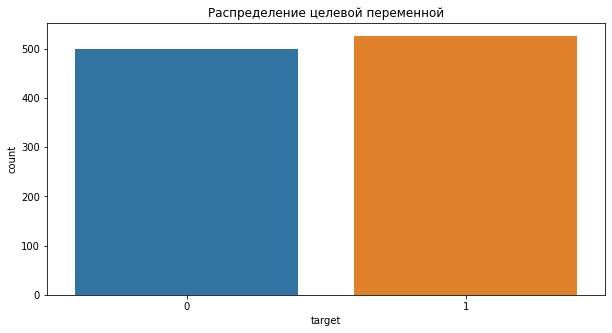

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

sns.countplot(data=df, x="target")
plt.title('Распределение целевой переменной');


Дизбаланс классов отсутствует

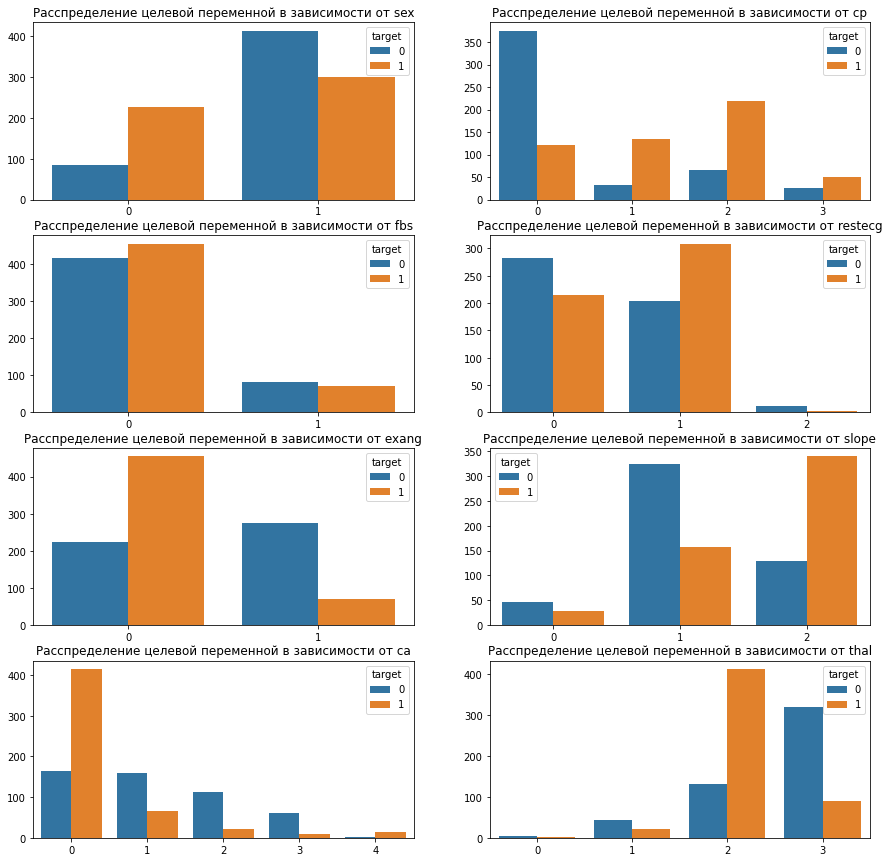

In [11]:
plt.figure(figsize=(15,15))
for i, c in enumerate(cat_col):
    plt.subplot(4,2, i+1)
    sns.countplot(data=df, x=c, hue="target")
    plt.xlabel('')
    plt.ylabel('')

    plt.title(f'Расспределение целевой переменной в зависимости от {c}')

In [12]:
num_col = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

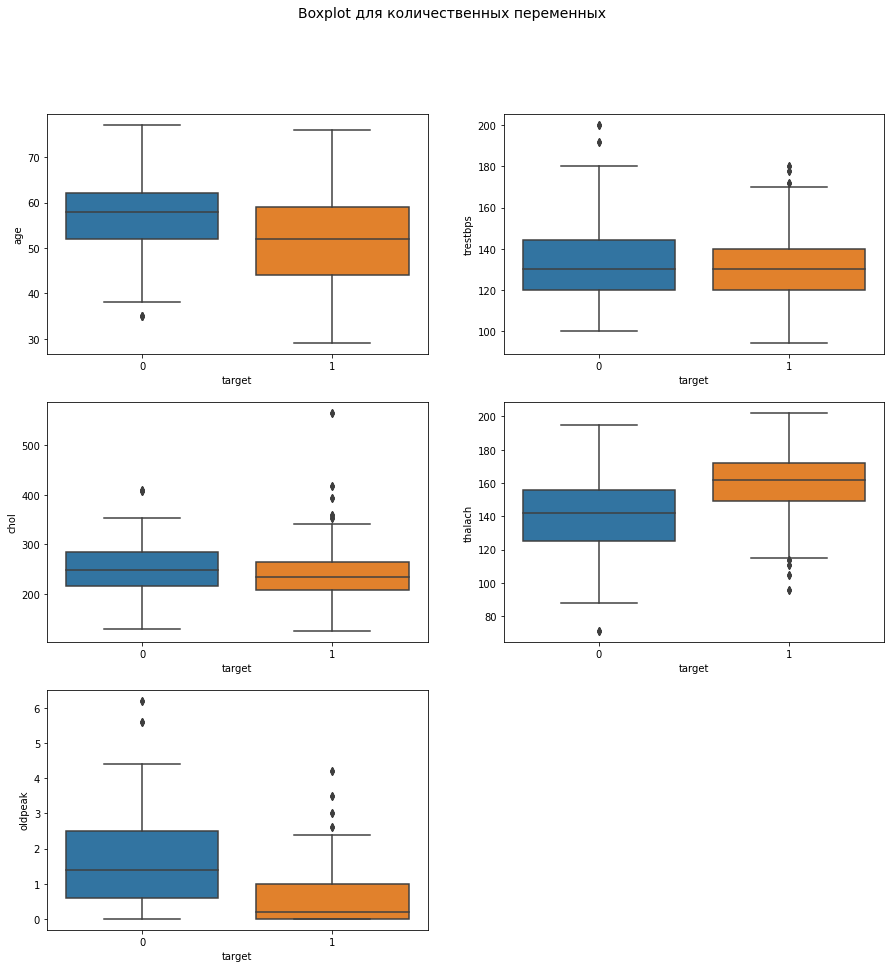

In [13]:
plt.figure(figsize=(15, 15))
plt.suptitle("Boxplot для количественных переменных", fontsize=14)
for i, num in enumerate(num_col):
    plt.subplot(3,2, i+1)
    sns.boxplot(y=df[num], x=df['target'])


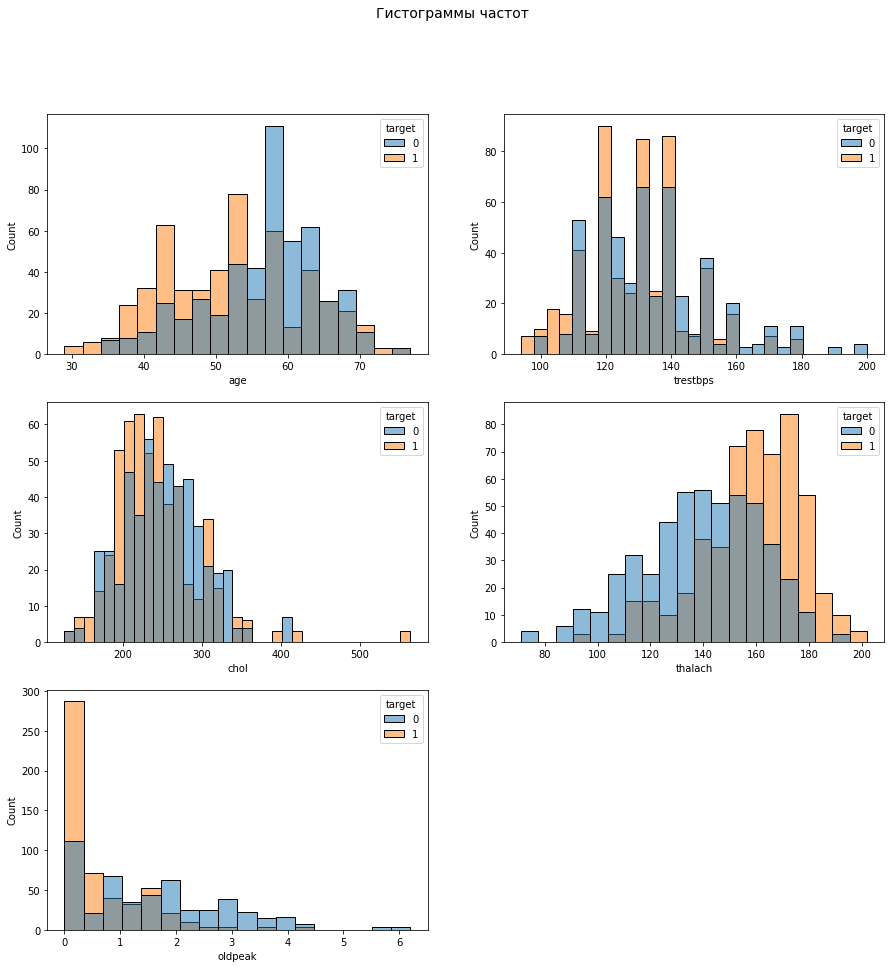

In [14]:
plt.figure(figsize=(15, 15))
plt.suptitle("Гистограммы частот", fontsize=14)
for i, num in enumerate(num_col):
    plt.subplot(3,2, i+1)
    sns.histplot(df, x=num, hue="target")


In [15]:
num_targ = pd.concat([df[num_col], df['target']], axis=1)


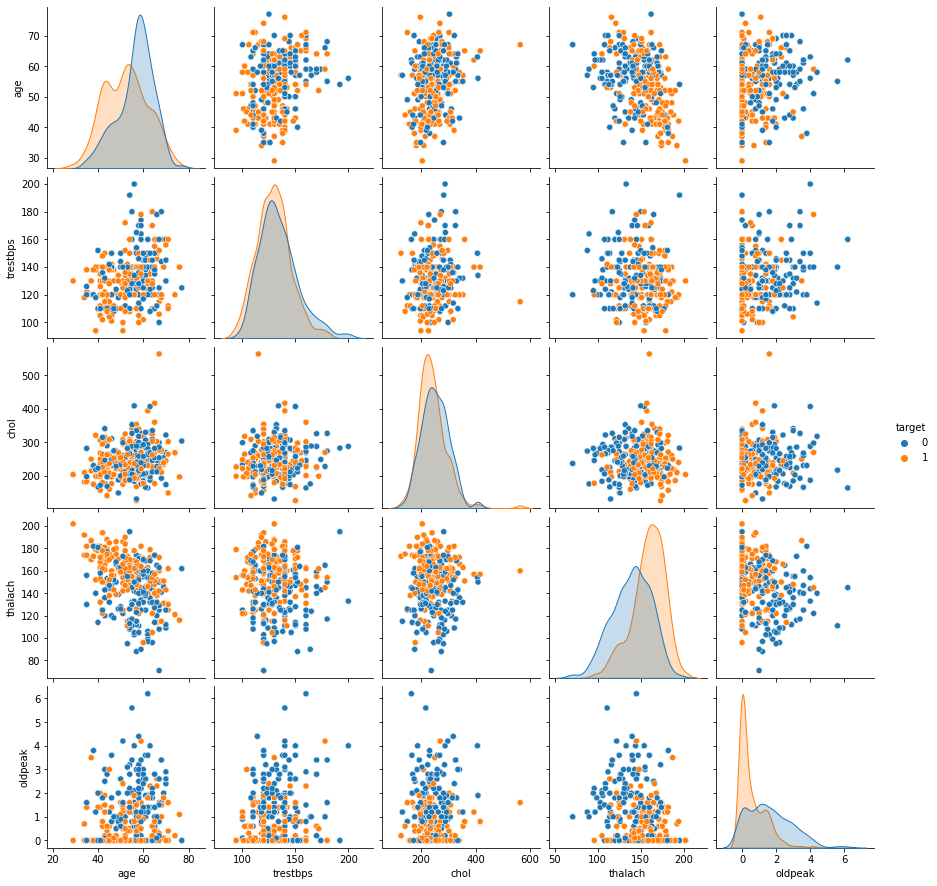

In [16]:
sns.pairplot(num_targ, hue='target')

#### Кодирование категориальных переменных

In [17]:
df = pd.get_dummies(df, columns=cat_col2code)

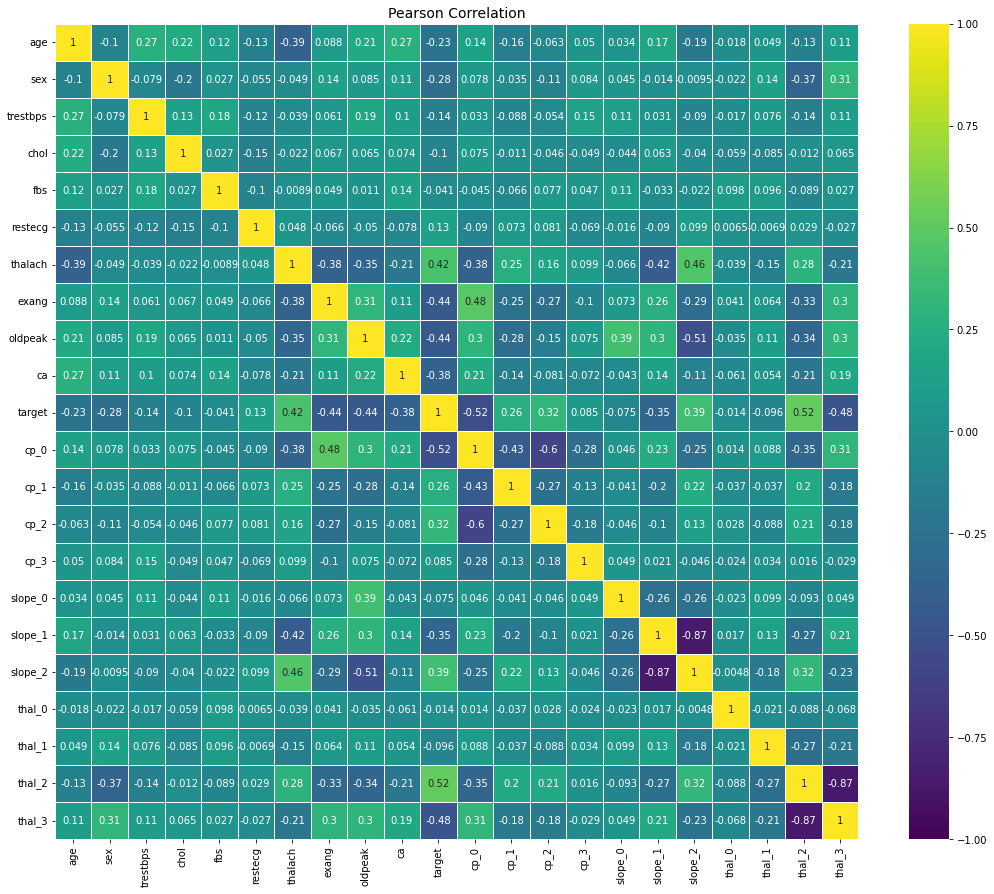

In [18]:
correlation = df.corr()
corr = plt.figure(figsize=(18, 15))
corr = sns.heatmap(correlation, vmax=1, vmin=-1,
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white")
corr.set_title("Pearson Correlation",fontsize= 14)

plt.show()


In [19]:
y = df['target']
X = df.drop(columns=['target'])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)


#### Выбор признаков

In [21]:
estimator = LogisticRegression(random_state=1)
selector = RFECV(estimator)
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_



array([1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
X.columns[selector.support_]

Index(['age', 'sex', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca',
       'cp_0', 'cp_1', 'cp_2', 'cp_3', 'slope_0', 'slope_1', 'slope_2',
       'thal_0', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')

In [23]:
X = X[X.columns[selector.support_]]

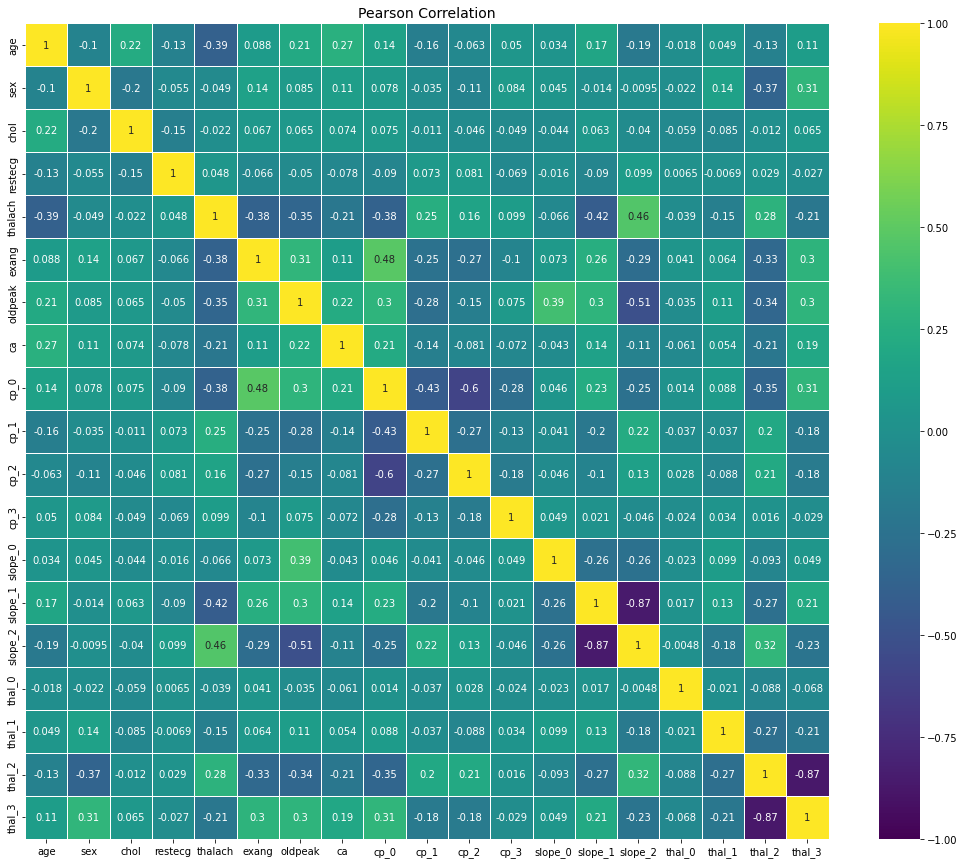

In [24]:
correlation = X.corr()
corr = plt.figure(figsize=(18, 15))
corr = sns.heatmap(correlation, vmax=1, vmin=-1,
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white")
corr.set_title("Pearson Correlation",fontsize= 14)

plt.show()


In [25]:
#X = X.drop(columns=["slope_1", "thal_2"], axis=0) #удалим сильно коррелирующие переменные

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

scaler = StandardScaler() 

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
dct = {}
def result(test, pred, model):
    print(f'model: {(model)}')
    print(f'Accuracy_score: {accuracy_score(test, pred)}')
    print(f'Precission_score: {precision_score(test, pred)}')
    print(f'Recall_score: {recall_score(test, pred)}')
    print(f'F1-score: {f1_score(test, pred)}')
    dct[(model)] = {'F-score': f1_score(test, pred),"accuracy": accuracy_score(test, pred),
                       'precision':precision_score(test, pred),'recall': recall_score(test, pred) }


### Дерево решений

In [28]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': range (1, 20, 1),
              'criterion' :['gini', 'entropy']}


clf = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)


grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'max_features': ['auto', 'sqrt', 'log2']})

In [29]:
tr = grid.best_estimator_
tr.fit(X_train_scaled, y_train)

pred = tr.predict(X_test_scaled)
cm_tree = confusion_matrix(y_test, pred)
print(grid.best_params_)
result(y_test, pred, "Tree")


{'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto'}
model: Tree
Accuracy_score: 0.9766536964980544
Precission_score: 1.0
Recall_score: 0.952
F1-score: 0.9754098360655737


### Логистическая регрессия

In [30]:
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-4,3,8),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

skf = StratifiedKFold(n_splits=5)

clf = LogisticRegression(random_state=42 )

grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [31]:
logreg = grid.best_estimator_
logreg.fit(X_train_scaled, y_train)

pred = logreg.predict(X_test_scaled)
cm_logreg = confusion_matrix(y_test, pred)
print(grid.best_params_)
result(y_test, pred, "logreg")

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
model: logreg
Accuracy_score: 0.7898832684824902
Precission_score: 0.7669172932330827
Recall_score: 0.816
F1-score: 0.7906976744186045


### SVM

In [32]:
param_grid = {'C': np.logspace(-1,4,6),  'kernel':['rbf', 'poly']}
  
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=skf)
  
grid.fit(X_train_scaled, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(random_state=42),
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'kernel': ['rbf', 'poly']})

In [33]:
svm = grid.best_estimator_
svm.fit(X_train_scaled, y_train)
pred = svm.predict(X_test_scaled)
cm_svm = confusion_matrix(y_test, pred)

print(grid.best_params_)
result(y_test, pred, "SVM")

{'C': 100.0, 'kernel': 'poly'}
model: SVM
Accuracy_score: 0.9766536964980544
Precission_score: 1.0
Recall_score: 0.952
F1-score: 0.9754098360655737


### KNN

In [34]:
param_grid = {'n_neighbors': list(range(1, 40)), 
              'weights': ['uniform', 'distance'],
              'metric' : ['manhattan', 'euclidean', 'cosine']
              } 



In [35]:
clf = KNeighborsClassifier()

grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train_scaled, y_train)
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

In [36]:
knn = grid.best_estimator_
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)
cm_knn = confusion_matrix(y_test, pred)

print(grid.best_params_)
result(y_test, pred, "KNN")

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
model: KNN
Accuracy_score: 0.9883268482490273
Precission_score: 1.0
Recall_score: 0.976
F1-score: 0.9878542510121457


### Наивный Байес

In [37]:
param_grid = {'var_smoothing': np.logspace(0,-12, num=200)}

In [38]:
clf = GaussianNB()

grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train_scaled, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.70359136e-01, 7.57525026e-01, 6.59318827e-01,
       5.73844165e-01, 4.99450512e-01, 4.34701316e-01, 3.78346262e-01,
       3.29297126e-01, 2.86606762e-01, 2.49450814e-01, 2.17111795e-01,
       1.88965234e-01, 1.64467618e-01, 1.4314...
       2.43744415e-11, 2.12145178e-11, 1.84642494e-11, 1.60705282e-11,
       1.39871310e-11, 1.21738273e-11, 1.05956018e-11, 9.22197882e-12,
       8.02643352e-12, 6.98587975e-12, 6.08022426e-12, 5.29197874e-12,
       4.60592204e-12, 4.00880633e-12, 3.48910121e-12, 3.03677112e-12,
       2.64308149e-12, 2.30043012e-12, 2.00220037e-12, 1.74263339e-12,
       1.51671689e-12, 1.32008840e-12, 1.14895100e-12, 1.00000000e-12])})

In [39]:
bayes = grid.best_estimator_
bayes.fit(X_train_scaled, y_train)
pred = bayes.predict(X_test_scaled)
cm_bayes = confusion_matrix(y_test, pred)
print(grid.best_params_)

result(y_test, pred, "naive bayes")

{'var_smoothing': 0.37834626171319297}
model: naive bayes
Accuracy_score: 0.8054474708171206
Precission_score: 0.7659574468085106
Recall_score: 0.864
F1-score: 0.8120300751879698


### Реализация Логистической регрессии

In [40]:
mylog = MyLogisticRegression()

parameters = {
    'lr' : np.logspace(-4, 0, 5),
    'max_iters' : np.logspace(1, 7, 7)}

grid = GridSearchCV(mylog, param_grid = parameters, scoring='accuracy', cv=skf)
grid.fit(X_train_scaled, y_train)

my_log_reg = grid.best_estimator_
my_log_reg.fit(X_train_scaled, y_train)
pred = my_log_reg.predict(X_test_scaled)
cm_my_log_reg = confusion_matrix(y_test, pred)

print(grid.best_params_)
result(y_test, pred, "MyLogReg")


{'lr': 0.1, 'max_iters': 10.0}
model: MyLogReg
Accuracy_score: 0.7898832684824902
Precission_score: 0.7669172932330827
Recall_score: 0.816
F1-score: 0.7906976744186045


### Реализация KNN

In [41]:
myknn = MyKNN()

parameters = {'k': list(range(1, 20)), 
              'metric' : ['manhattan', 'euclidean']} 


grid = GridSearchCV(myknn, param_grid=parameters, scoring='accuracy', cv=skf)
grid.fit(X_train_scaled, y_train)

my_knn = grid.best_estimator_
my_knn.fit(X_train_scaled, y_train)
pred = my_knn.predict(X_test_scaled)
cm_my_knn= confusion_matrix(y_test, pred)

print(grid.best_params_)
result(y_test, pred, "My KNN")


{'k': 1, 'metric': 'manhattan'}
model: My KNN
Accuracy_score: 0.9649805447470817
Precission_score: 1.0
Recall_score: 0.928
F1-score: 0.9626556016597512


### Метрики

In [42]:
res = pd.DataFrame(dct).T
res

,F-score,accuracy,precision,recall
Tree,0.975410,0.976654,1.000000,0.952
logreg,0.790698,0.789883,0.766917,0.816
SVM,0.975410,0.976654,1.000000,0.952
KNN,0.987854,0.988327,1.000000,0.976
naive bayes,0.812030,0.805447,0.765957,0.864
MyLogReg,0.790698,0.789883,0.766917,0.816
My KNN,0.962656,0.964981,1.000000,0.928


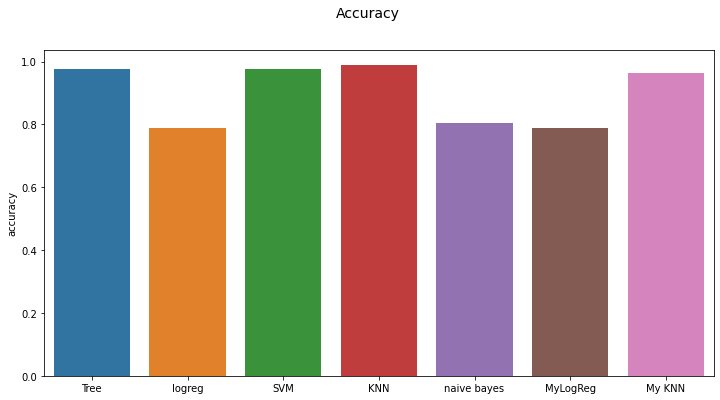

In [43]:
plt.figure(figsize=(12, 6))
plt.suptitle("Accuracy", fontsize=14)

sns.barplot(y=res['accuracy'], x=res['accuracy'].index);


### Лучший результат показала модель KNN, немного отстают Дерево решений и SVM

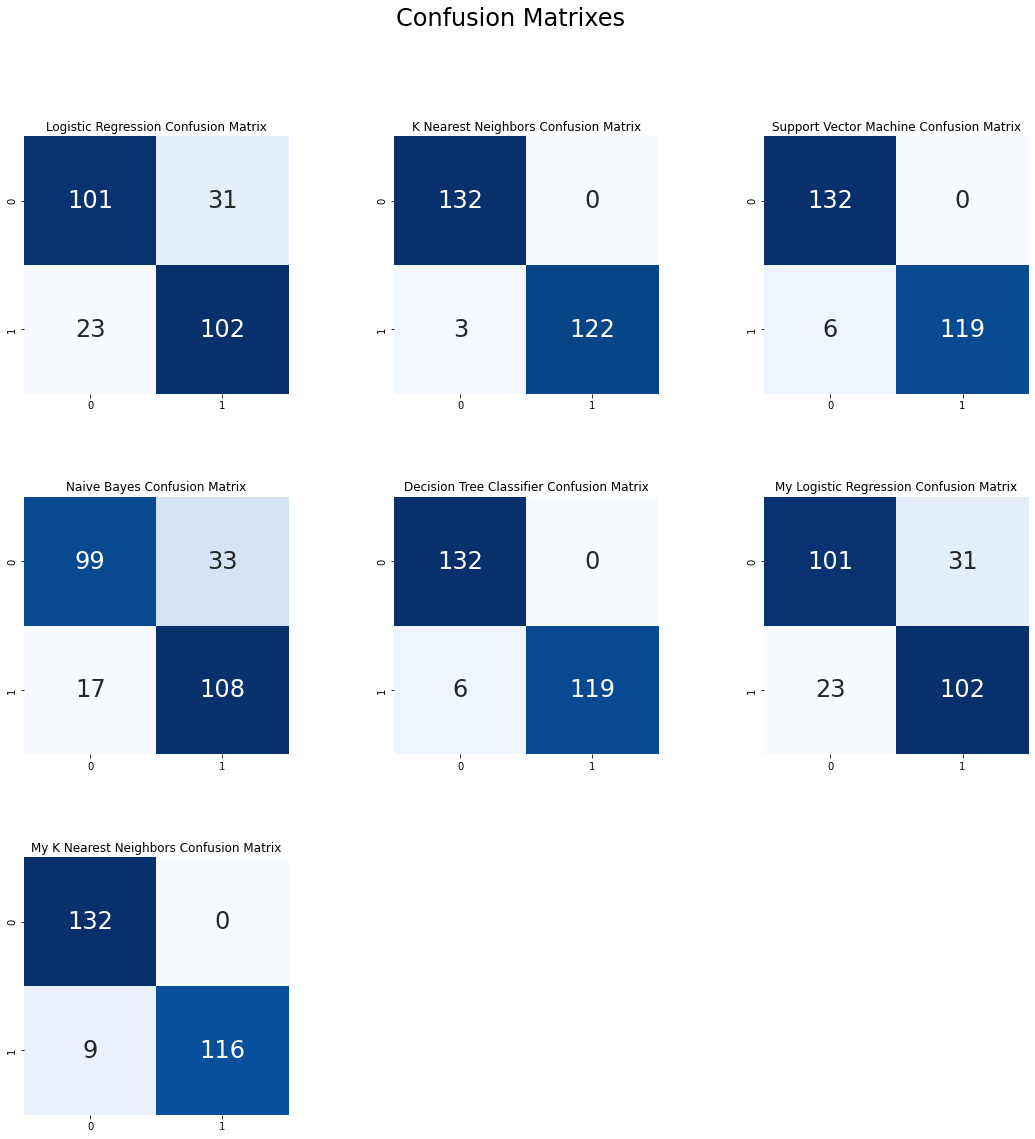

In [44]:
plt.figure(figsize=(18, 18))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_logreg,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_bayes,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_tree,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("My Logistic Regression Confusion Matrix")
sns.heatmap(cm_my_log_reg, annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,7)
plt.title("My K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_my_knn, annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})


plt.show()


## Набор данных - Набор данных анкеты для прогнозирования уровня знаний, чтобы защитить ребенка / Прогноз осведомленности о насилии над детьми 
https://www.kaggle.com/datasets/sahasourav17/child-sexual-abuse-awareness-knowledge-level

In [45]:
df = pd.read_csv('CSA-Data.csv')

### Разведочный анализ данных

In [46]:
df.head()

,"""Children are safe among family members such as grandparents, uncles, aunts, cousins""","""Children are mainly abused by strangers in our society""",Male children dont need sexual abuse prevention knowledge,"""Teaching sexual abuse prevention in school is not necessary. It will make children curious about sex""",Do you know what child grooming is?,Do you know what signs to look for to identify if your child has been abused?,Do you think children need post abuse counseling for recovering?,Do you think you should take legal action against the abuser of your child?,Knowledge Level
0,Agree,Agree,Disagree,Agree,No,No,No,Yes,Beginner
1,Agree,Agree,Disagree,Disagree,No,No,Yes,Yes,Beginner
2,Disagree,Disagree,Disagree,Disagree,No,No,Yes,Yes,Beginner
3,Agree,Agree,Disagree,Disagree,No,No,Yes,Yes,Beginner
4,Agree,Disagree,Disagree,Disagree,Yes,Yes,Yes,Yes,Intermediate


In [47]:
df.isna().sum().sum()


0

In [48]:
df.describe(include='all')

,"""Children are safe among family members such as grandparents, uncles, aunts, cousins""","""Children are mainly abused by strangers in our society""",Male children dont need sexual abuse prevention knowledge,"""Teaching sexual abuse prevention in school is not necessary. It will make children curious about sex""",Do you know what child grooming is?,Do you know what signs to look for to identify if your child has been abused?,Do you think children need post abuse counseling for recovering?,Do you think you should take legal action against the abuser of your child?,Knowledge Level
count,3002,3002,3002,3002,3002,3002,3002,3002,3002
unique,2,2,2,2,2,2,2,2,2
top,Disagree,Disagree,Disagree,Disagree,No,No,Yes,Yes,Beginner
freq,1632,1700,1908,1657,1626,1521,2111,1928,1711


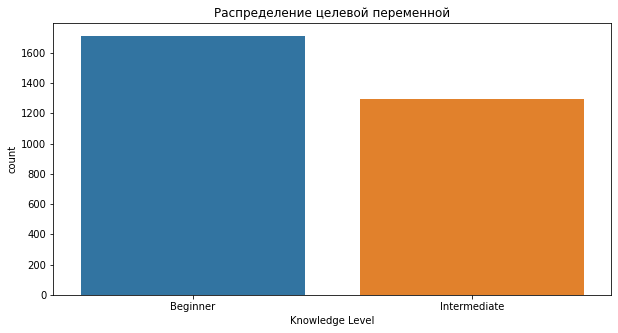

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

sns.countplot(data=df, x="Knowledge Level")
plt.title('Распределение целевой переменной');


In [50]:
col = df.columns[:-1]

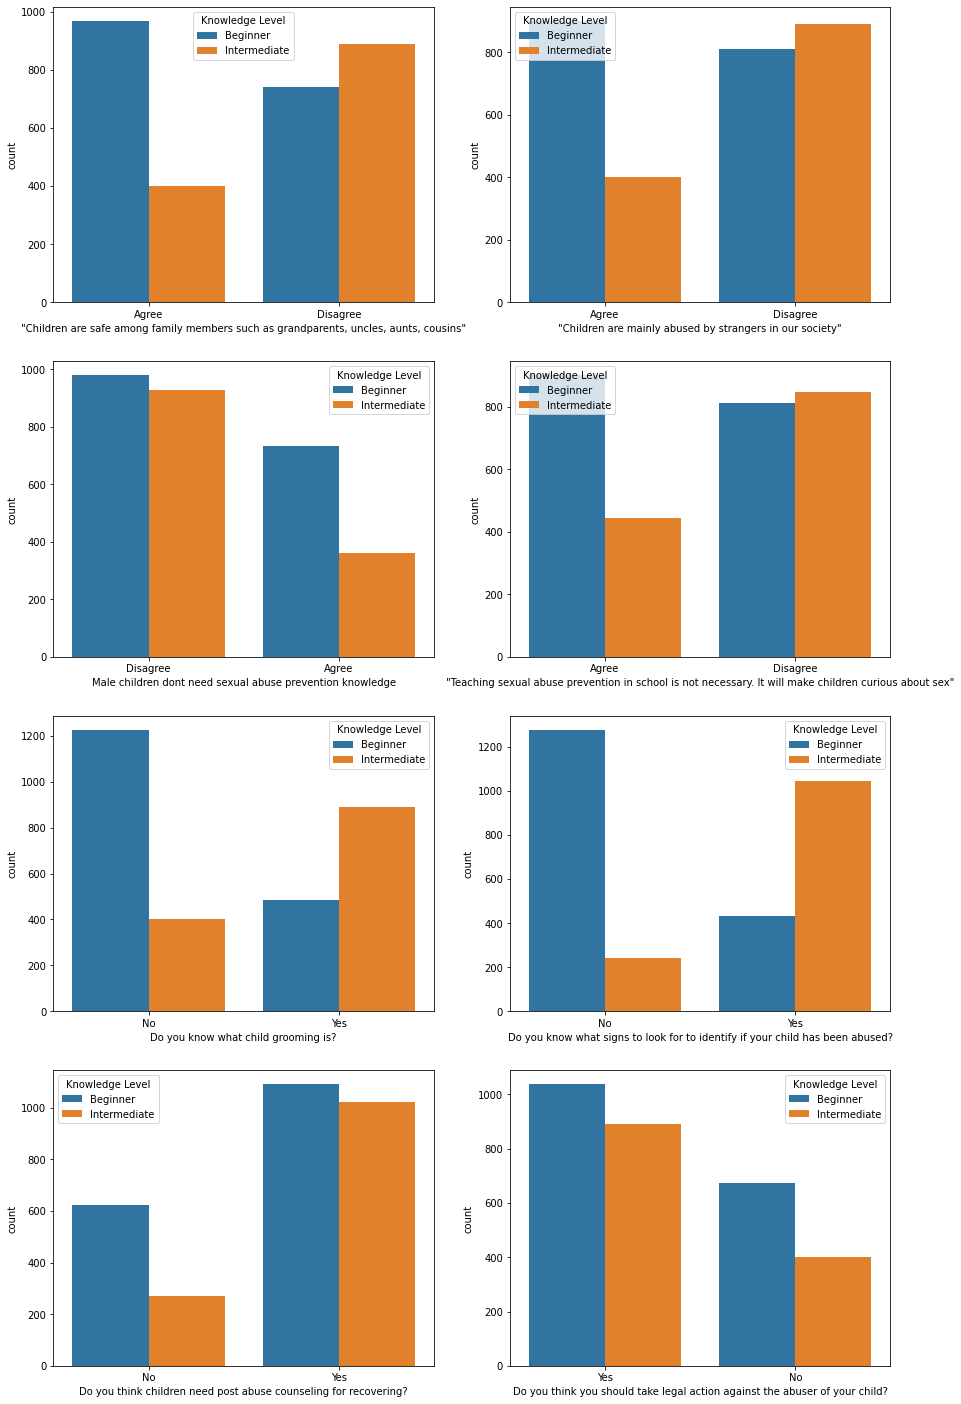

In [51]:
plt.figure(figsize=(15, 25))
for i, column in enumerate(col):
    plt.subplot(4,2, i+1)
    sns.countplot(data=df, x=column, hue='Knowledge Level')


### Кодирование переменных

In [52]:
for i in df.columns:
    df[i] = df[i].map({'Yes':1, 'No':0, 'Agree':1, 'Disagree':0, 'Beginner':0, 'Intermediate':1})


In [53]:
df.head()

,"""Children are safe among family members such as grandparents, uncles, aunts, cousins""","""Children are mainly abused by strangers in our society""",Male children dont need sexual abuse prevention knowledge,"""Teaching sexual abuse prevention in school is not necessary. It will make children curious about sex""",Do you know what child grooming is?,Do you know what signs to look for to identify if your child has been abused?,Do you think children need post abuse counseling for recovering?,Do you think you should take legal action against the abuser of your child?,Knowledge Level
0,1,1,0,1,0,0,0,1,0
1,1,1,0,0,0,0,1,1,0
2,0,0,0,0,0,0,1,1,0
3,1,1,0,0,0,0,1,1,0
4,1,0,0,0,1,1,1,1,1


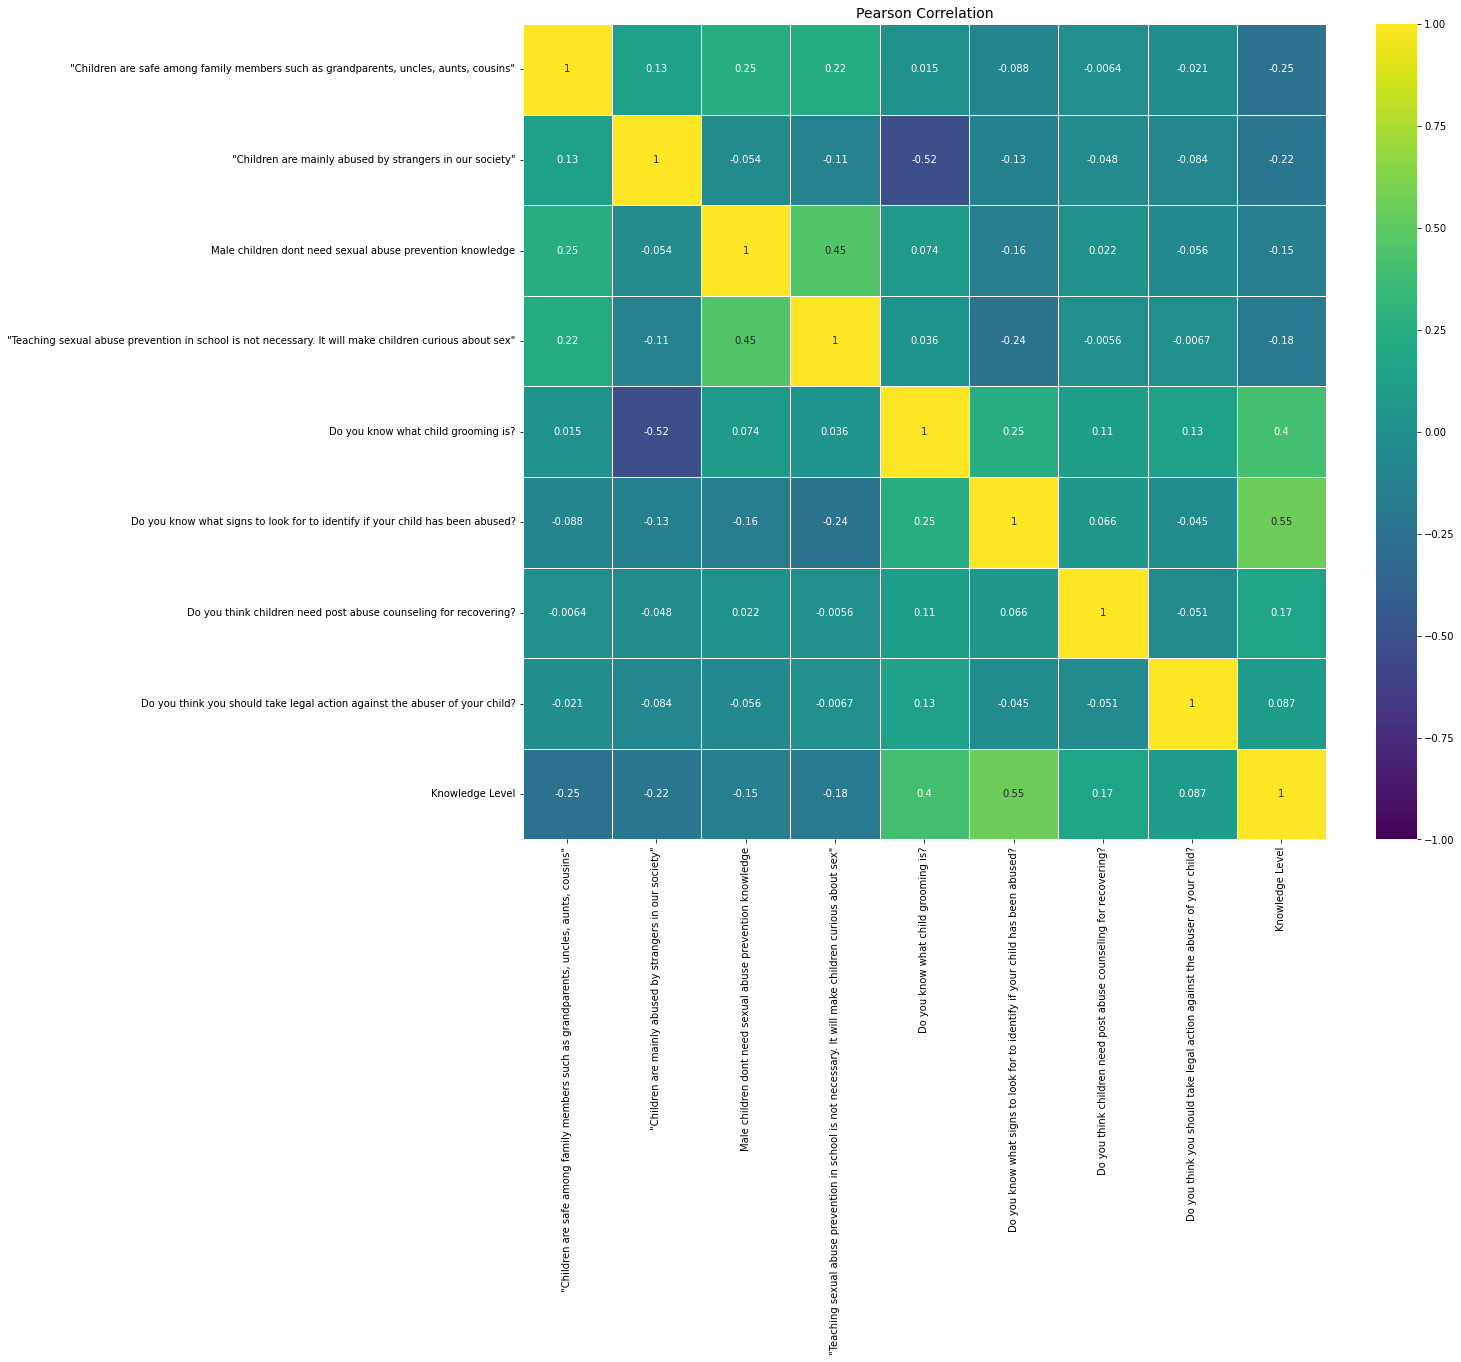

In [54]:
correlation = df.corr()
corr = plt.figure(figsize=(18, 15))
corr = sns.heatmap(correlation, vmax=1, vmin=-1,
            linewidths=0.5, annot=True,cmap='viridis',
            linecolor="white")
corr.set_title("Pearson Correlation",fontsize= 14)

plt.show()


In [55]:
y = df['Knowledge Level']
X = df.drop('Knowledge Level', axis=1)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)


#### Выбор признаков

In [57]:
estimator = DecisionTreeClassifier(random_state=42)
selector = RFECV(estimator)
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_


array([1, 1, 1, 1, 1, 1, 1, 1])

In [58]:
dct = {}

### Логистическая регрессия

In [59]:
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-4,3,8),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}

skf = StratifiedKFold(n_splits=5)

clf = LogisticRegression(random_state=42 )

grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [60]:
logreg = grid.best_estimator_
logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)

cm_logreg = confusion_matrix(y_test, pred)
print(grid.best_params_)
result(y_test, pred, "logreg")

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
model: logreg
Accuracy_score: 0.8362183754993342
Precission_score: 0.8057142857142857
Recall_score: 0.8367952522255193
F1-score: 0.8209606986899564


### Дерево решений

In [61]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              
              'max_depth': range (1, 20, 1),
              'criterion' :['gini', 'entropy']}


clf = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5)


grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train, y_train)


tr = grid.best_estimator_
tr.fit(X_train, y_train)

pred = tr.predict(X_test)
cm_tree = confusion_matrix(y_test, pred)
print(grid.best_params_)
result(y_test, pred, "Tree")



{'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2'}
model: Tree
Accuracy_score: 0.9227696404793608
Precission_score: 0.8907563025210085
Recall_score: 0.9436201780415431
F1-score: 0.9164265129682997


### KNN

In [62]:
param_grid = {'n_neighbors': list(range(1, 40)), 
              'weights': ['uniform', 'distance'],
              'metric' : ['minkowski', 'euclidean']} 


clf = KNeighborsClassifier()

grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train, y_train)
grid.best_params_

knn = grid.best_estimator_
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, pred)

print(grid.best_params_)
result(y_test, pred, "KNN")

{'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
model: KNN
Accuracy_score: 0.9241011984021305
Precission_score: 0.8977272727272727
Recall_score: 0.9376854599406528
F1-score: 0.9172714078374455


### Наивный Байес

In [63]:
param_grid = {'var_smoothing': np.logspace(2,-4, num=1000)}

clf = GaussianNB()

grid = GridSearchCV(clf, param_grid, cv=skf)
grid.fit(X_train, y_train)

bayes = grid.best_estimator_
bayes.fit(X_train, y_train)
pred = bayes.predict(X_test)
cm_bayes = confusion_matrix(y_test, pred)
print(grid.best_params_)

result(y_test, pred, "naive bayes")

{'var_smoothing': 1.3005112521734092}
model: naive bayes
Accuracy_score: 0.8308921438082557
Precission_score: 0.8
Recall_score: 0.8308605341246291
F1-score: 0.8151382823871908


### SVM

In [64]:
param_grid = {'C': np.logspace(-1,4,6),  'kernel':['rbf', 'poly']}
  
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=skf)
  
grid.fit(X_train, y_train)

svm = grid.best_estimator_
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
cm_svm = confusion_matrix(y_test, pred)

print(grid.best_params_)
result(y_test, pred, "SVM")

{'C': 10.0, 'kernel': 'poly'}
model: SVM
Accuracy_score: 0.9214380825565912
Precission_score: 0.8904494382022472
Recall_score: 0.9406528189910979
F1-score: 0.9148629148629148


### Реализация Лог регрессии

In [65]:
mylog = MyLogisticRegression()

parameters = {
    'lr' : np.logspace(-4, 0, 5),
    'max_iters' : np.logspace(1, 7, 7)}

grid = GridSearchCV(mylog, param_grid = parameters, scoring='accuracy', cv=skf)
grid.fit(X_train, y_train)

my_log_reg = grid.best_estimator_
my_log_reg.fit(X_train, y_train)
pred = my_log_reg.predict(X_test)
cm_my_log_reg = confusion_matrix(y_test, pred)

print(grid.best_params_)
result(y_test, pred, "MyLogReg")


{'lr': 1.0, 'max_iters': 10.0}
model: MyLogReg
Accuracy_score: 0.8362183754993342
Precission_score: 0.8057142857142857
Recall_score: 0.8367952522255193
F1-score: 0.8209606986899564


### Метрики

In [66]:
res = pd.DataFrame(dct).T
res

,F-score,accuracy,precision,recall
logreg,0.820961,0.836218,0.805714,0.836795
Tree,0.916427,0.922770,0.890756,0.943620
KNN,0.917271,0.924101,0.897727,0.937685
naive bayes,0.815138,0.830892,0.800000,0.830861
SVM,0.914863,0.921438,0.890449,0.940653
MyLogReg,0.820961,0.836218,0.805714,0.836795


In [67]:
res = pd.DataFrame(dct).T
res

,F-score,accuracy,precision,recall
logreg,0.820961,0.836218,0.805714,0.836795
Tree,0.916427,0.922770,0.890756,0.943620
KNN,0.917271,0.924101,0.897727,0.937685
naive bayes,0.815138,0.830892,0.800000,0.830861
SVM,0.914863,0.921438,0.890449,0.940653
MyLogReg,0.820961,0.836218,0.805714,0.836795


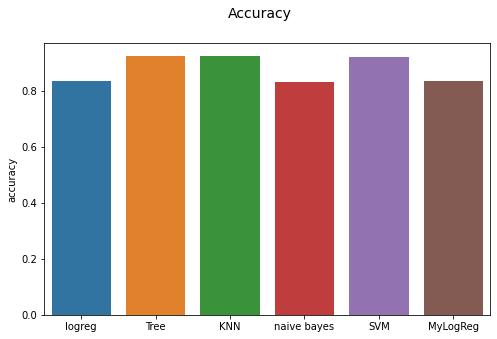

In [68]:
plt.figure(figsize=(8, 5))
plt.suptitle("Accuracy", fontsize=14)

sns.barplot(y=res['accuracy'], x=res['accuracy'].index);


### KNN, SVM и дерево решений показали практически идентичные результаты, превзошедшие остальные модели

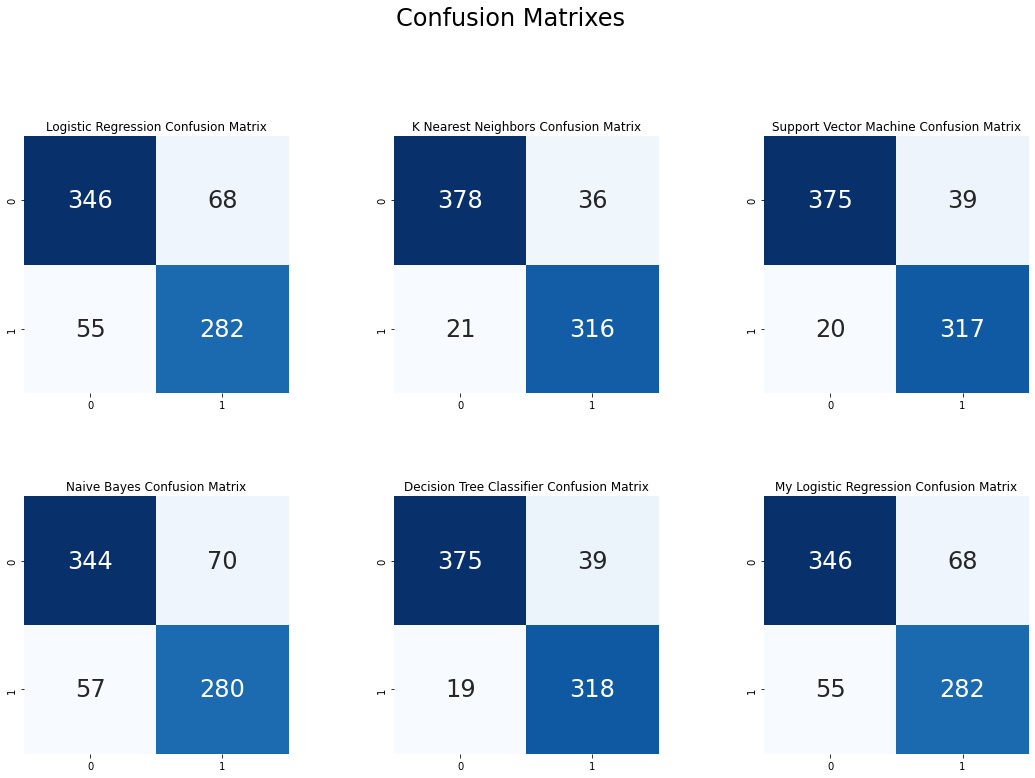

In [69]:
plt.figure(figsize=(18, 18))

plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_logreg,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_bayes,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_tree,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("My Logistic Regression Confusion Matrix")
sns.heatmap(cm_my_log_reg,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()
